# Benchmark

## Imports

In [15]:
import os
import pickle

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from _ood_classifier import OODDetector
from aiirw import AI_IRW
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

sns.set_style('white')
from sklearn.metrics import average_precision_score, roc_auc_score

## Data loading and formatting

In [16]:
with open('embeddings_imbd_train.pkl', 'rb') as f:
    embd_train = pickle.load(f)

with open('logits_imdb_train.pkl', 'rb') as f:
    logit_train = pickle.load(f)

with open('attns_imdb_train.pkl', 'rb') as f:
    attn_train = pickle.load(f)

In [17]:
embd_ood = []
logit_ood = []
attn_ood = []
ood_dict = {}

for fn in [el for el in os.listdir() if el.startswith('embeddings_ood_test_')]:

    _name = fn.split('_')[-1].split('.')[0]
    _vars = {}

    with open(fn, 'rb') as f:
        _embd = pickle.load(f)
    embd_ood += _embd

    _vars['embd'] = _embd

    with open(f"logits_ood_test_{_name}.pkl", 'rb') as f:
        _logit = pickle.load(f)
    logit_ood += _logit

    _vars['logit'] = _logit

    with open(f"attns_ood_test_{_name}.pkl", 'rb') as f:
        _attn = pickle.load(f)
    attn_ood += _attn

    _vars['attn'] = _attn   

    ood_dict[_name] = _vars 

In [18]:
with open('embeddings_imdb_test.pkl', 'rb') as f:
    embd_test = pickle.load(f)

with open('logits_imdb_test.pkl', 'rb') as f:
    logit_test = pickle.load(f)

with open('attns_imdb_test.pkl', 'rb') as f:
    attn_test = pickle.load(f)

In [19]:
logit_train = torch.cat(logit_train).numpy()
attn_train = torch.cat(attn_train).numpy()
embd_train = torch.cat(embd_train).numpy()

embd_train_distrib  = {l: embd_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}
attn_train_distrib  = {l: attn_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}
logit_train_distrib  = {l: logit_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}

In [20]:
logit_test = torch.cat(logit_test).numpy()
embd_test = torch.cat(embd_test).numpy()
attn_test = torch.cat(attn_test).numpy()


embd_test_distrib  = {l: embd_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}
attn_test_distrib  = {l: attn_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}
logit_test_distrib  = {l: logit_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}



In [21]:

# Aggregated
logit_ood = torch.cat(logit_ood).numpy()
embd_ood = torch.cat(embd_ood).numpy()
attn_ood = torch.cat(attn_ood).numpy()

embd_ood_distrib  = {l: embd_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}
attn_ood_distrib  = {l: attn_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}
logit_ood_distrib  = {l: logit_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}



#Per OOD-DS
for el in ood_dict.values():
    for _k, _v in el.items():
       el[_k] = torch.cat(_v).numpy()
        
    el['embd_ood_distrib']  = {l: el['embd'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}
    el['attn_ood_distrib']  = {l: el['attn'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}
    el['logit_ood_distrib']  = {l: el['logit'][np.where(np.argmax(el['logit'], axis=-1)==l)] for l in range(el['logit'].shape[1])}

    




In [22]:
X_0_embd =  np.concatenate((embd_ood_distrib[0], embd_test_distrib[0]))
X_0_attn =  np.concatenate((attn_ood_distrib[0], attn_test_distrib[0]))
y_0 =   np.concatenate((np.ones((embd_ood_distrib[0].shape[0])), np.zeros((embd_test_distrib[0].shape[0]))))

X_1_embd =  np.concatenate((embd_ood_distrib[1], embd_test_distrib[1]))
X_1_attn =  np.concatenate((attn_ood_distrib[1], attn_test_distrib[1]))
y_1 =   np.concatenate((np.ones((embd_ood_distrib[1].shape[0])), np.zeros((embd_test_distrib[1].shape[0]))))

X_embd = np.concatenate((logit_ood, logit_test))
X_attn = np.concatenate((attn_ood, attn_test))
y_ = np.concatenate((np.ones(logit_ood.shape[0]), np.zeros(logit_test.shape[0])))

## Benchmark of classifier

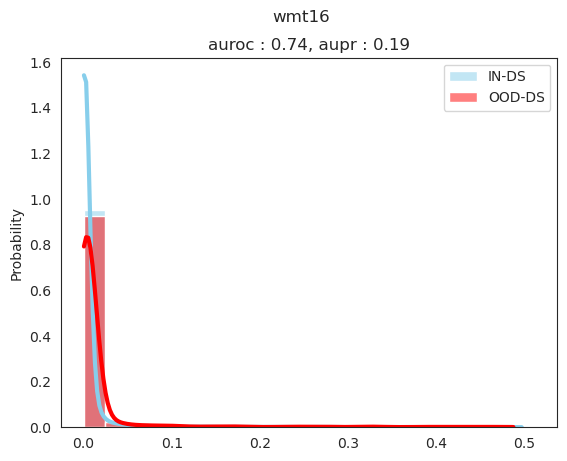

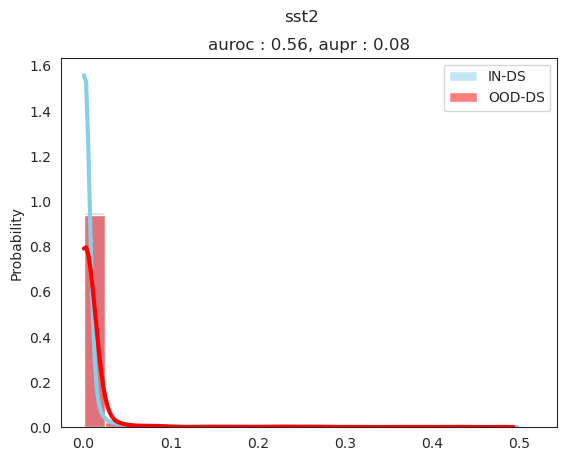

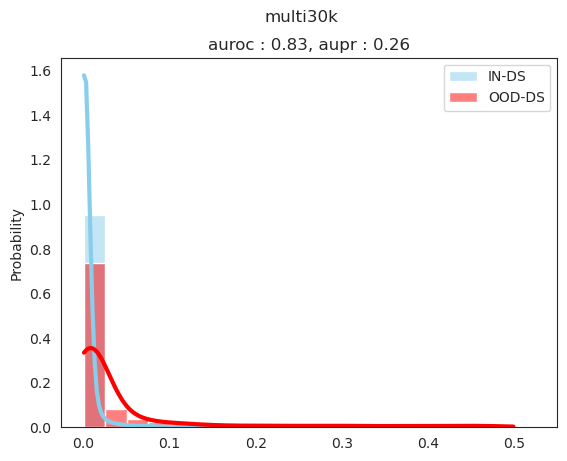

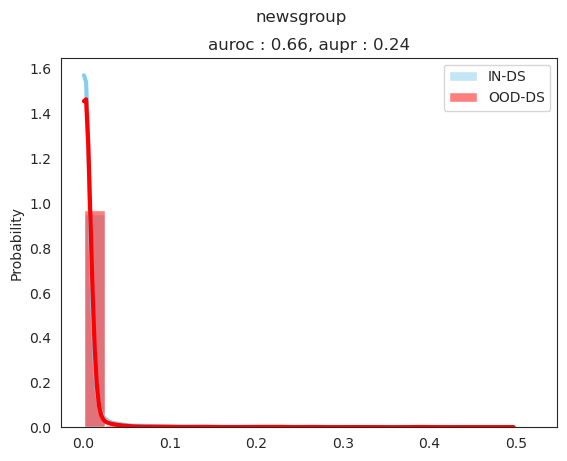

 Weighted mean [0.71715586 0.21385121]
Mean [0.69630715 0.19023447]


In [23]:
selected_idx = np.random.randint(0,attn_train_distrib[0].shape[0], (2000,2))
clfs = {
    i: OODDetector(
        similarity='MSP',
        base_distribution=attn_train_distrib[i],#[selected_idx[:,i]],
        T=10
     )
     .fit() for i in [0,1]
}
# Careful to change the attn/logits/embd according to the classifier

scores=[]
weights=[]
for ds_n,ood_ds in ood_dict.items():
    y_score_tot = []
    y_true_tot = []
    score_for_1__ds = []
    for i in [0,1]:
        clf = clfs[i]
        y_true = np.concatenate((np.ones(ood_ds['logit_ood_distrib'][i].shape[0]), np.zeros(logit_test_distrib[i].shape[0])))
        X = np.concatenate((ood_ds['logit_ood_distrib'][i] ,logit_test_distrib[i]))
        y_score = clf.predict_proba(X).flatten()
        auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
        aupr = average_precision_score(y_true=y_true, y_score=y_score)
        scores.append([auc_score, aupr])
        score_for_1__ds.append([auc_score, aupr])
        y_score_tot.append(y_score)
        y_true_tot.append(y_true)
        weights.append(len(y_true))

    y_score_tot = np.concatenate(y_score_tot)
    y_true_tot = np.concatenate(y_true_tot)

    bins_width = (np.histogram(y_score_tot[y_true_tot==1])[1][3]-np.histogram(y_score_tot[y_true_tot==1])[1][2])/2
    sns.histplot(y_score_tot[y_true_tot==0], label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
    sns.histplot(y_score_tot[y_true_tot==1], label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
    _a = np.mean(score_for_1__ds, axis=0)
    plt.title(f"auroc : {_a[0]:.2f}, aupr : {_a[1]:.2f}")

    plt.suptitle(ds_n)
    plt.legend()
    plt.show()

scores, weights = np.array(scores), np.array(weights)/(np.sum(weights))
print(f" Weighted mean {scores.T@weights}")
print(f"Mean {np.mean(scores, axis=0)}")
    

## Grid Search 

In [63]:
#import random search from sklearn
from sklearn.model_selection import RandomizedSearchCV
#import shuffle from sklearn
from sklearn.utils import shuffle

X_0, y_0 = shuffle(X_0, y_0)
X_1, y_1 = shuffle(X_1, y_1)
X_, y_ = shuffle(X_, y_)

# Create the parameter grid based on the results of random search, tau follows a gaussian centered in 50 with std 10
param_grid = {
    'tau': np.random.uniform(-150, 0, 100), 
    'similarity': ['mahalanobis'],
    'base_distribution' : [train_distrib[0]]
}

# Create a based model
clf = OODDetector(similarity='mahalanobis', tau=50, base_distribution=train_distrib[0])

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid,
                            cv = 5, n_jobs = -1, verbose = 0, scoring='balanced_accuracy')


NameError: name 'X_0' is not defined

In [41]:
grid_search.fit(X_0, y_0)
print(grid_search.best_params_)

{'tau': -53.24070283187717, 'similarity': 'mahalanobis', 'base_distribution': array([[ 0.1655158 ,  0.19259338, -0.05701194, ..., -0.04087529,
         0.06450007,  0.27201617],
       [ 0.26176506,  0.13326405,  0.04254614, ..., -0.02392149,
         0.06750306,  0.20914446],
       [ 0.16050506, -0.07738341,  0.21776502, ..., -0.1432903 ,
        -0.04918719, -0.1345499 ],
       ...,
       [-0.07087212, -0.27570873,  0.08874413, ..., -0.14185995,
        -0.05530067, -0.18070912],
       [-0.13870718, -0.08804137, -0.18017988, ..., -0.1654126 ,
        -0.06333739, -0.11101169],
       [ 0.00867541, -0.23554574,  0.14202845, ..., -0.29557773,
        -0.16673136, -0.346024  ]], dtype=float32)}


In [17]:
grid_search.best_score_

0.9770796974985456